In [ ]:
# ==== HARD REPAIR: Numpy ABI fix + runtime restart ====
import os, sys, glob, shutil, IPython

# 1) Problemli paketleri kaldır
!pip -q uninstall -y numpy opencv-python opencv-python-headless opencv-contrib-python opencv-contrib-python-headless ultralytics >/dev/null

# 2) Site-packages içindeki eski numpy klasörlerini fiziken sil
for site in [sys.prefix, sys.exec_prefix]:
    for p in glob.glob(os.path.join(site, "lib", f"python{sys.version_info.major}.{sys.version_info.minor}", "dist-packages", "numpy*")):
        shutil.rmtree(p, ignore_errors=True)
print("🧹 Eski numpy klasörleri temizlendi.")

# 3) Temiz kurulum (NumPy 2.x) — hızlı teker
!pip -q install --no-cache-dir "numpy==2.1.1"

import numpy as _np
print("NumPy kuruldu:", _np.__version__)

# 4) Runtime'ı ZORLA yeniden başlat
print("Runtime yeniden başlatılıyor...")
IPython.display.clear_output(wait=True)
os.kill(os.getpid(), 9)


In [1]:
# =============================================
# NEON Tree Detection (YOLOv8) - Colab Free Safe (Single Cell, FIXED)
# setup → prepare → train(640) → fine-tune(1024) → predict & previews → counts (Drive)
# =============================================

# --- Sabit kurulum: SIRA ÖNEMLİ! ---
!pip -q install --no-cache-dir "opencv-python-headless==4.10.0.84"
!pip -q install --no-cache-dir torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121
!pip -q install --no-cache-dir "ultralytics==8.3.179" rasterio

import os, glob, shutil, random, csv, xml.etree.ElementTree as ET, yaml, sys, gc
import numpy as np, cv2
from ultralytics import YOLO
from google.colab import drive
from google.colab.patches import cv2_imshow

# Versiyon kontrol (mtrand hatasını burada yakalayalım)
import numpy, numpy.random as npr
print("NumPy:", numpy.__version__)
print("OpenCV:", cv2.__version__)
_ = npr.RandomState(0).rand(1)  # mtrand import testi

# W&B kapalı
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 356.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 244.6 MB/s eta 0:00:00
WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
NumPy: 2.1.1
OpenCV: 4.12.0


In [2]:
# ---------- CONFIG ----------
BASE_PATH   = "/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc"
IMG_DIR     = f"{BASE_PATH}/evaluation/RGB"
XML_DIR     = f"{BASE_PATH}/annotations"
YOLO_TXT    = f"{BASE_PATH}/yolo_labels"
SPLIT_DIR   = f"{BASE_PATH}/data_split"
RUNS_DIR    = f"{BASE_PATH}/runs"            # Tüm deney çıktılarını DİREKT Drive’a yaz
MODELS_DIR  = f"{BASE_PATH}/trained_models"
PREVIEW_DIR = f"{BASE_PATH}/previews"

CLASSES   = ["Tree"]
VAL_RATIO = 0.2
SEED      = 42

# Hiperparametre
EPOCHS_640, IMGSZ_640, BATCH_GPU, BATCH_CPU = 100, 640, 8, 4
EPOCHS_1024, IMGSZ_1024, FT_LR0, FT_LRF    = 20, 1024, 0.002, 0.1
CONF_640, CONF_1024, IOU                   = 0.25, 0.22, 0.6


In [3]:
# ---------- SOME FUNCTIONS ----------
def banner(m): print("\n"+ "="*len(m) + f"\n{m}\n" + "="*len(m))
def ensure_dir(p): os.makedirs(p, exist_ok=True); return p
def detect_device():
    import torch
    is_cuda = torch.cuda.is_available()
    dev = 0 if is_cuda else "cpu"
    print(f"CUDA available: {is_cuda} | device={dev}")
    return dev

def convert_xml_to_yolo(xml_dir, out_dir, classes):
    ensure_dir(out_dir)
    xmls = [x for x in os.listdir(xml_dir) if x.lower().endswith(".xml")]
    assert xmls, f"❌ '{xml_dir}' içinde .xml yok."
    for xf in xmls:
        xp = os.path.join(xml_dir, xf)
        try:
            root = ET.parse(xp).getroot()
            size = root.find('size')
            if size is None:
                print("⚠️ size yok:", xf); continue
            w = int(size.find('width').text); h = int(size.find('height').text)
            if w == 0 or h == 0:
                print("⚠️ width/height 0:", xf); continue
            lines = []
            for obj in root.findall('object'):
                name = obj.find('name').text
                if name not in classes:
                    continue
                cid = classes.index(name)
                b = obj.find('bndbox')
                xmin = float(b.find('xmin').text); ymin = float(b.find('ymin').text)
                xmax = float(b.find('xmax').text); ymax = float(b.find('ymax').text)
                cx = ((xmin+xmax)/2.0)/w; cy=((ymin+ymax)/2.0)/h
                bw = (xmax-xmin)/w;      bh=(ymax-ymin)/h
                cx = float(np.clip(cx,0,1)); cy=float(np.clip(cy,0,1))
                bw = float(np.clip(bw,0,1));  bh=float(np.clip(bh,0,1))
                if bw<=0 or bh<=0: continue
                lines.append(f"{cid} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")
            with open(os.path.join(out_dir, xf.replace(".xml",".txt")), "w") as f:
                f.write("\n".join(lines))
        except Exception as e:
            print("❌ XML hata:", xp, e)
    print(f"✅ XML → YOLO tamam ({len(xmls)} dosya). Out:", out_dir)

def split_train_val(img_dir, lbl_dir, split_dir, val_ratio=0.2, seed=42):
    train_img = ensure_dir(os.path.join(split_dir, "train", "images"))
    train_lbl = ensure_dir(os.path.join(split_dir, "train", "labels"))
    val_img   = ensure_dir(os.path.join(split_dir, "val",   "images"))
    val_lbl   = ensure_dir(os.path.join(split_dir, "val",   "labels"))
    for d in [train_img, train_lbl, val_img, val_lbl]:
        for g in glob.glob(os.path.join(d, "*")): os.remove(g)
    exts = (".tif",".tiff",".png",".jpg",".jpeg")
    all_imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(exts)]
    yolo_txts = set(os.listdir(lbl_dir))
    pairs = [f for f in all_imgs if (os.path.splitext(f)[0]+".txt") in yolo_txts]
    assert pairs, "❌ Eşleşen görüntü-etiket çifti yok."
    rng = random.Random(seed); rng.shuffle(pairs)
    n_val = max(1, int(val_ratio * len(pairs)))
    val_files, train_files = pairs[:n_val], pairs[n_val:]
    def cp(files, dimg, dlbl):
        for fn in files:
            shutil.copy2(os.path.join(img_dir, fn), os.path.join(dimg, fn))
            shutil.copy2(os.path.join(lbl_dir, os.path.splitext(fn)[0]+".txt"),
                         os.path.join(dlbl, os.path.splitext(fn)[0]+".txt"))
    cp(train_files, train_img, train_lbl)
    cp(val_files,   val_img,   val_lbl)
    print(f"📦 Train: {len(train_files)} | Val: {len(val_files)}")
    return os.path.join(split_dir,"train","images"), os.path.join(split_dir,"val","images")

def write_data_yaml(split_dir, classes):
    data_yaml = os.path.join(split_dir, "data.yaml")
    with open(data_yaml, "w") as f:
        yaml.dump({"train": os.path.join(split_dir,"train","images"),
                   "val":   os.path.join(split_dir,"val","images"),
                   "nc": len(classes), "names": classes}, f)
    print("✅ data.yaml:", data_yaml)
    return data_yaml

def train_stage(base_weights, data_yaml, imgsz, epochs, run_name, device, batch_gpu=8, batch_cpu=4, lr0=None, lrf=None):
    banner(f"🧠 Train: {run_name} | imgsz={imgsz} | epochs={epochs}")
    model = YOLO(base_weights)
    batch = batch_gpu if device == 0 else batch_cpu
    args = dict(data=data_yaml, epochs=epochs, imgsz=imgsz, batch=batch,
                device=device, workers=0, cache=False, project=RUNS_DIR, name=run_name,
                save_period=0, seed=SEED, verbose=True)
    if lr0 is not None: args["lr0"] = lr0
    if lrf is not None: args["lrf"] = lrf
    try:
        model.train(**args)
    except Exception as e:
        print("⚠️ Eğitim hatası:", e, "→ Batch yarıya düşüyor…")
        import gc; gc.collect()
        args["batch"] = max(1, batch//2)
        model.train(**args)
    best_path = os.path.join(RUNS_DIR, run_name, "weights", "best.pt")
    print("✅ Eğitim bitti. best:", best_path)
    return best_path

def predict_and_preview(model_path, source, imgsz, conf, iou, name, device, preview_n=3):
    banner(f"🔎 Predict & Preview: {name} | imgsz={imgsz} | conf={conf}")
    model = YOLO(model_path)
    model.predict(source=source, imgsz=imgsz, conf=conf, iou=iou, device=device,
                  save=True, save_txt=True, project=RUNS_DIR, name=name, workers=0, verbose=False)
    pred_dir = os.path.join(RUNS_DIR, name)
    ensure_dir(PREVIEW_DIR)
    shown = 0
    for p in sorted(glob.glob(os.path.join(pred_dir, "*"))):
        if os.path.isdir(p): continue
        if os.path.splitext(p)[1].lower() in (".jpg",".jpeg",".png",".tif",".tiff"):
            img = cv2.imread(p)
            if img is None: continue
            print("👀", os.path.basename(p))
            cv2_imshow(img)
            cv2.imwrite(os.path.join(PREVIEW_DIR, f"{name}_{shown:02d}.jpg"), img)
            shown += 1
            if shown >= preview_n: break
    if shown == 0: print("⚠️ Önizleme bulunamadı.")
    return pred_dir

def predict_labels_only(model_path, source_dir, imgsz, conf, iou, name, device):
    banner(f"🧾 Predict (labels only): {name}")
    model = YOLO(model_path)
    model.predict(source=source_dir, imgsz=imgsz, conf=conf, iou=iou, device=device,
                  save=False, save_txt=True, project=RUNS_DIR, name=name, workers=0, verbose=False)
    return os.path.join(RUNS_DIR, name, "labels")

def labels_to_counts_csv(labels_dir, out_csv):
    rows = []
    for p in sorted(glob.glob(os.path.join(labels_dir, "*.txt"))):
        with open(p) as f: n = sum(1 for _ in f)
        rows.append([os.path.basename(p).replace(".txt",""), n])
    ensure_dir(os.path.dirname(out_csv))
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["image_stem","count"]); w.writerows(rows)
    print(f"✅ CSV kaydedildi: {out_csv} | Toplam kutu: {sum(r[1] for r in rows)}")
    return rows

In [4]:
# ---------- 1) Drive ----------
banner("Google Drive")
drive.mount('/content/drive')
for d in [YOLO_TXT, SPLIT_DIR, RUNS_DIR, MODELS_DIR, PREVIEW_DIR]: ensure_dir(d)



Google Drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# ---------- 2) XML → YOLO ----------
banner("XML → YOLO")
convert_xml_to_yolo(XML_DIR, YOLO_TXT, CLASSES)



XML → YOLO
✅ XML → YOLO tamam (227 dosya). Out: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/yolo_labels


In [6]:
# ---------- 3) Split + YAML ----------
banner("Train/Val split")
_, _ = split_train_val(IMG_DIR, YOLO_TXT, SPLIT_DIR, VAL_RATIO, SEED)
DATA_YAML = write_data_yaml(SPLIT_DIR, CLASSES)



Train/Val split
📦 Train: 156 | Val: 38
✅ data.yaml: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/data.yaml


In [7]:
# ---------- 4) Device ----------
device = detect_device()


CUDA available: True | device=0


In [8]:
# ---------- 5) Train 640 ----------
best640 = train_stage("yolov8m.pt", DATA_YAML, IMGSZ_640, EPOCHS_640, "tree_yolov8m_640",
                      device, BATCH_GPU, BATCH_CPU)
shutil.copy2(best640, os.path.join(MODELS_DIR, "tree_det_640.pt"))


🧠 Train: tree_yolov8m_640 | imgsz=640 | epochs=100
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tree_yolov8m_640, nbs=64, nms=False, opset=None, opt

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           


  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384, 576, 3, 2]              
  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576,

AMP: checks passed ✅
train: Fast image access ✅ (ping: 8.9±19.3 ms, read: 122.4±97.7 MB/s, size: 559.2 KB)


train: Scanning /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/train/labels... 156 images, 0 backgrounds, 0 corrupt: 100%|██████████| 156/156 [00:00<00:00, 158.85it/s]

train: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/train/images/BLAN_005_2019.tif: 1 duplicate labels removed
train: New cache created: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 218.1±30.9 MB/s, size: 515.9 KB)


val: Scanning /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/val/labels... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 186.74it/s]

val: New cache created: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/val/labels.cache


Plotting labels to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.74G      2.542      2.661      2.032        103        640: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         38       1353      0.296      0.333       0.24     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.38G      2.169      1.993      1.744        173        640: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         38       1353     0.0365      0.303     0.0237    0.00883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.39G      2.124      1.879      1.771        152        640: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         38       1353     0.0409      0.301     0.0262    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.39G      2.221      1.887      1.803        179        640: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         38       1353      0.129      0.375     0.0902     0.0323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.39G      2.143      1.818      1.697        259        640: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         38       1353     0.0833      0.191     0.0403     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.39G      2.135       1.83      1.716        319        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         38       1353    0.00431     0.0355    0.00248    0.00078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.39G        2.1      1.705      1.704        115        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         38       1353      0.212      0.231      0.118     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.39G      2.112      1.759      1.693         60        640: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         38       1353       0.34      0.357      0.256     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.39G      2.109      1.728      1.702        518        640: 100%|██████████| 20/20 [00:13<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         38       1353      0.375      0.344      0.293      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.39G      2.091      1.696      1.633         87        640: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         38       1353      0.422      0.375      0.327      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.39G      2.033      1.573      1.623        160        640: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         38       1353        0.4      0.442      0.361      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.39G      2.014      1.671      1.653        175        640: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         38       1353      0.306      0.398      0.213     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.39G      2.084      1.659      1.672         81        640: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         38       1353      0.405      0.378       0.32      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.39G      2.056       1.64       1.66        126        640: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         38       1353      0.379      0.361       0.31      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.39G      1.994      1.622      1.652        307        640: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         38       1353      0.417      0.388      0.342      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.39G      2.066      1.585      1.619        180        640: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         38       1353      0.466      0.389      0.365      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.39G      2.047      1.564      1.601        134        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         38       1353       0.47      0.395      0.373      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.39G      2.008      1.635      1.625        100        640: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         38       1353      0.491      0.433      0.419      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.39G      1.978      1.531      1.587        139        640: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


                   all         38       1353      0.422      0.431      0.363      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.39G      2.009      1.491      1.578        102        640: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         38       1353      0.528      0.455      0.443      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.39G       1.96      1.542      1.609         99        640: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         38       1353      0.481      0.438      0.421      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.39G      1.984      1.549      1.592        227        640: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


                   all         38       1353      0.525      0.465      0.473      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.13G      1.988      1.467      1.549        224        640: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

                   all         38       1353      0.561      0.439      0.451       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.13G      1.986      1.492      1.573        150        640: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         38       1353      0.478      0.482      0.451      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.13G      1.925      1.464      1.568        141        640: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


                   all         38       1353      0.544      0.452       0.47      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.13G      1.908      1.436      1.535        178        640: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         38       1353      0.516      0.487      0.482      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.13G       1.92      1.442      1.574        123        640: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         38       1353      0.524      0.417      0.434      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.13G      2.021      1.446      1.553        175        640: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         38       1353      0.503      0.421      0.431       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.13G      1.898      1.433      1.573        197        640: 100%|██████████| 20/20 [00:08<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         38       1353      0.397      0.439      0.374      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.13G      1.929      1.471      1.566        182        640: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         38       1353      0.445      0.407      0.372      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.13G      1.904      1.432      1.532        185        640: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         38       1353      0.545      0.443       0.45      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.13G      1.892      1.384      1.538        287        640: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         38       1353      0.515      0.444      0.447      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.13G      1.907      1.393      1.524        166        640: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


                   all         38       1353      0.561      0.465      0.471      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.13G       1.88      1.338      1.518        177        640: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         38       1353      0.546      0.497      0.497      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.13G      1.862      1.384      1.535        267        640: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

                   all         38       1353      0.575      0.463      0.481      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.13G      1.868      1.334      1.518        147        640: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         38       1353      0.538      0.492      0.482      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.13G      1.867      1.363      1.552        229        640: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         38       1353      0.548      0.492      0.487      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.13G      1.891      1.299      1.528        137        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         38       1353      0.565      0.495      0.508      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.13G      1.894      1.298      1.549        118        640: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         38       1353      0.538      0.483      0.487      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.13G      1.845      1.332      1.545        184        640: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         38       1353      0.518      0.478      0.456      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.13G      1.865      1.329      1.522        103        640: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         38       1353      0.557      0.475      0.492      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.13G      1.879      1.344      1.563        237        640: 100%|██████████| 20/20 [00:08<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         38       1353      0.555       0.48        0.5      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.13G       1.81      1.285      1.497        368        640: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         38       1353      0.535       0.46      0.462      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.13G      1.858      1.285      1.495        276        640: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         38       1353      0.553      0.499      0.485      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.13G      1.813      1.254      1.488        190        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         38       1353      0.602      0.497       0.53      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.13G      1.815      1.235      1.486        105        640: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         38       1353      0.552      0.517      0.513      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.13G      1.844      1.227      1.484        305        640: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         38       1353      0.578      0.482      0.488      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.13G      1.775      1.199      1.482        137        640: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         38       1353       0.56      0.483      0.507      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.13G      1.754      1.173       1.48        328        640: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         38       1353      0.528      0.511      0.497        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.13G      1.798      1.226      1.517        116        640: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         38       1353      0.537      0.482      0.501      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.13G      1.823      1.214      1.474        150        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all         38       1353      0.537      0.501        0.5      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.13G      1.754      1.184      1.482        356        640: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         38       1353      0.519      0.508      0.486      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.13G      1.759      1.166       1.45         57        640: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all         38       1353      0.566      0.499      0.514      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.13G      1.788      1.171       1.48        221        640: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         38       1353      0.559      0.471      0.497      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.13G      1.773       1.14       1.47        151        640: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         38       1353       0.53      0.484      0.492      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.13G      1.752      1.158      1.481        180        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         38       1353      0.544      0.517      0.515       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.13G       1.71      1.138       1.46        231        640: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         38       1353      0.592      0.478      0.516      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.13G      1.732      1.084      1.415        185        640: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         38       1353      0.586       0.52      0.525      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.13G      1.716      1.099      1.449        160        640: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         38       1353      0.574      0.491      0.504      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.13G      1.685      1.103      1.456         88        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         38       1353      0.592       0.49      0.525      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.13G      1.691      1.062      1.424        308        640: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         38       1353      0.531      0.492      0.491      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.13G      1.704      1.037      1.396        275        640: 100%|██████████| 20/20 [00:08<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         38       1353      0.586      0.464       0.51      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.13G      1.671      1.099       1.48        143        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         38       1353      0.579      0.493      0.526      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.13G      1.668      1.049      1.436        112        640: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         38       1353      0.584      0.511      0.533      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.13G      1.642      1.026      1.419        415        640: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         38       1353      0.521      0.503      0.484      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.13G      1.649      1.027      1.401        144        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


                   all         38       1353      0.517      0.502      0.478      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.13G      1.637      1.024      1.406        130        640: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         38       1353      0.575      0.505      0.515      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.13G      1.628      1.006      1.407        115        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         38       1353      0.596      0.506       0.52      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.13G      1.661      1.036      1.437        150        640: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         38       1353      0.567      0.534      0.523      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.13G      1.622     0.9728      1.384        161        640: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


                   all         38       1353      0.539      0.535      0.506      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.13G      1.611     0.9434      1.351         73        640: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         38       1353      0.596      0.494      0.526      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.13G      1.582     0.9314      1.373         93        640: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         38       1353      0.632      0.473      0.525      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.13G      1.575     0.9206      1.369        205        640: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         38       1353      0.563       0.52      0.526      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.13G      1.575     0.9374      1.371        248        640: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


                   all         38       1353      0.564      0.524      0.524      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.13G      1.555     0.9163      1.369        156        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         38       1353      0.563      0.514      0.522      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.13G      1.576     0.9115      1.366        287        640: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         38       1353      0.592      0.493      0.529      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.13G      1.547     0.9252      1.368         43        640: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         38       1353      0.541      0.494      0.493      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.13G       1.55     0.8804      1.337        369        640: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         38       1353       0.58      0.467      0.498      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.13G       1.54     0.8775      1.317        251        640: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         38       1353       0.59      0.499      0.514      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.13G      1.491     0.8629      1.336        181        640: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         38       1353      0.589      0.504      0.516      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.13G      1.541     0.8741      1.355        137        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         38       1353      0.564      0.531      0.528      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.13G      1.532     0.8645      1.328        226        640: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         38       1353      0.592      0.503      0.517      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.13G      1.522     0.8656      1.308        129        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         38       1353      0.569      0.519      0.511      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.13G      1.465     0.8565      1.335        211        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         38       1353      0.538      0.514        0.5      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.13G      1.477     0.8405      1.317        278        640: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all         38       1353      0.528      0.519      0.496      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.13G      1.465     0.8138      1.302        137        640: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         38       1353      0.555      0.503      0.498      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.13G       1.47     0.8384      1.328        213        640: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         38       1353      0.564      0.514      0.508      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.13G      1.467     0.8395      1.331        106        640: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         38       1353      0.569      0.518      0.518      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.13G      1.462     0.8206      1.281        290        640: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         38       1353      0.581      0.493      0.516      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.13G      1.452     0.8121      1.298        305        640: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         38       1353      0.548      0.534      0.522      0.209


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.13G      1.461     0.8552      1.334         27        640: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         38       1353      0.548      0.516      0.507      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.13G      1.457     0.8325      1.318         45        640: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


                   all         38       1353      0.559      0.518       0.51      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.13G      1.419     0.7985      1.312        221        640: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         38       1353      0.563      0.539      0.509      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.13G      1.417     0.7611      1.289        239        640: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         38       1353      0.579      0.524      0.504      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.13G      1.391     0.7716      1.289        111        640: 100%|██████████| 20/20 [00:12<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         38       1353      0.576      0.517      0.501      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.13G      1.373     0.7779      1.292        103        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         38       1353       0.55      0.517        0.5      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.13G      1.395     0.7718      1.305         82        640: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         38       1353      0.539      0.511      0.498      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.13G      1.376     0.7441      1.296         74        640: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         38       1353      0.572      0.509      0.514      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.13G      1.344     0.7356      1.291         84        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

                   all         38       1353      0.589      0.497      0.519      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.13G      1.375     0.7422      1.269        127        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         38       1353      0.583      0.503      0.519      0.202



100 epochs completed in 0.348 hours.
Optimizer stripped from /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


                   all         38       1353      0.603      0.498       0.53      0.217
Speed: 0.5ms preprocess, 10.9ms inference, 0.0ms loss, 11.6ms postprocess per image
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640
✅ Eğitim bitti. best: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640/weights/best.pt


'/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/tree_det_640.pt'

In [9]:
# ---------- 6) Fine-tune 1024 ----------
best1024 = train_stage(best640, DATA_YAML, IMGSZ_1024, EPOCHS_1024, "tree_yolov8m_1024ft",
                       device, max(2, BATCH_GPU//2), max(1, BATCH_CPU//2), lr0=FT_LR0, lrf=FT_LRF)
shutil.copy2(best1024, os.path.join(MODELS_DIR, "tree_det_1024ft.pt"))



🧠 Train: tree_yolov8m_1024ft | imgsz=1024 | epochs=20
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_640/weights/best.pt, momentum=0.937

train: Scanning /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/train/labels.cache... 156 images, 0 backgrounds, 0 corrupt: 100%|██████████| 156/156 [00:00<?, ?it/s]

train: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/train/images/BLAN_005_2019.tif: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.7±0.7 ms, read: 167.4±89.0 MB/s, size: 515.9 KB)



val: Scanning /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/val/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]

Plotting labels to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_1024ft/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_1024ft
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.39G       1.94      1.724       1.78         82       1024: 100%|██████████| 39/39 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all         38       1353      0.481      0.414      0.402      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.22G      1.912      1.666      1.784        298       1024: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

                   all         38       1353      0.501       0.38      0.388      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.22G      1.945      1.772      1.871         74       1024: 100%|██████████| 39/39 [00:22<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all         38       1353      0.433       0.38      0.347      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.22G      1.999      1.717      1.894        300       1024: 100%|██████████| 39/39 [00:23<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

                   all         38       1353      0.478      0.414      0.401      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.22G      1.954      1.679      1.795        437       1024: 100%|██████████| 39/39 [00:26<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all         38       1353      0.457      0.387      0.352      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.22G      1.897      1.699      1.787        213       1024: 100%|██████████| 39/39 [00:22<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all         38       1353      0.479      0.431      0.398      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.22G      1.874      1.619      1.782         74       1024: 100%|██████████| 39/39 [00:22<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all         38       1353      0.506       0.48      0.463      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.22G      1.877      1.627       1.79         67       1024: 100%|██████████| 39/39 [00:26<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all         38       1353      0.521      0.452      0.461      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.22G      1.853      1.605      1.771        225       1024: 100%|██████████| 39/39 [00:25<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all         38       1353      0.507       0.46      0.462      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.22G      1.886      1.536      1.767        155       1024: 100%|██████████| 39/39 [00:26<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all         38       1353      0.503       0.46       0.47      0.195


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.22G      1.927      1.923      1.871        123       1024: 100%|██████████| 39/39 [00:24<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]

                   all         38       1353      0.505      0.424       0.43      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.22G      1.867      1.849      1.808        185       1024: 100%|██████████| 39/39 [00:21<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all         38       1353      0.541      0.451      0.462      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.22G      1.873      1.797      1.834        190       1024: 100%|██████████| 39/39 [00:21<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all         38       1353      0.514      0.429      0.439      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.22G      1.881      1.717      1.832        284       1024: 100%|██████████| 39/39 [00:21<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all         38       1353      0.505      0.448      0.457      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.22G      1.847      1.591      1.838        124       1024: 100%|██████████| 39/39 [00:21<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all         38       1353      0.531      0.486      0.506      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.22G      1.874      1.632      1.844        314       1024: 100%|██████████| 39/39 [00:25<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all         38       1353       0.58      0.478      0.512      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.22G       1.82       1.69      1.808         45       1024: 100%|██████████| 39/39 [00:25<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all         38       1353      0.546      0.476      0.495      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.22G      1.821      1.594      1.819        121       1024: 100%|██████████| 39/39 [00:21<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all         38       1353      0.544      0.502       0.52       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.22G      1.833      1.551      1.826        185       1024: 100%|██████████| 39/39 [00:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all         38       1353      0.567      0.501      0.522      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.22G      1.811      1.526      1.838         83       1024: 100%|██████████| 39/39 [00:21<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all         38       1353       0.57      0.491      0.515      0.212



20 epochs completed in 0.146 hours.
Optimizer stripped from /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_1024ft/weights/last.pt, 52.1MB
Optimizer stripped from /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_1024ft/weights/best.pt, 52.1MB

Validating /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_1024ft/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


                   all         38       1353       0.57      0.492      0.516      0.213
Speed: 1.3ms preprocess, 25.8ms inference, 0.0ms loss, 11.7ms postprocess per image
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_1024ft
✅ Eğitim bitti. best: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/tree_yolov8m_1024ft/weights/best.pt


'/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/tree_det_1024ft.pt'


🔎 Predict & Preview: preview_640_one | imgsz=640 | conf=0.25
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/preview_640_one
1 label saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/preview_640_one/labels
👀 YELL_062_2020.jpg


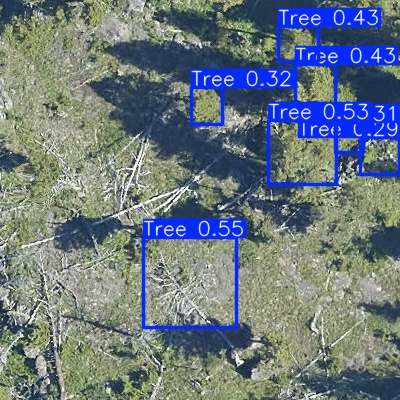


🔎 Predict & Preview: preview_1024_one | imgsz=1024 | conf=0.22
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/preview_1024_one
1 label saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/preview_1024_one/labels
👀 YELL_062_2020.jpg


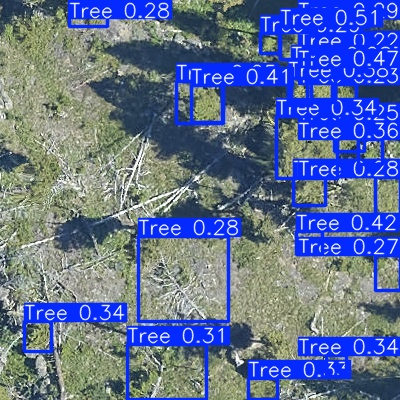

In [10]:
# ---------- 7) Tek görsel önizleme ----------
test_img = os.path.join(IMG_DIR, "YELL_062_2020.tif")
if not os.path.isfile(test_img):
    cand = (glob.glob(os.path.join(SPLIT_DIR, "val/images/*")) or
            glob.glob(os.path.join(SPLIT_DIR, "train/images/*")))
    test_img = cand[0] if cand else None
if test_img:
    predict_and_preview(os.path.join(MODELS_DIR, "tree_det_640.pt"),  test_img, IMGSZ_640,  CONF_640,  IOU, "preview_640_one",  device, preview_n=2)
    predict_and_preview(os.path.join(MODELS_DIR, "tree_det_1024ft.pt"),test_img, IMGSZ_1024, CONF_1024, IOU, "preview_1024_one", device, preview_n=2)
else:
    print("Önizleme için görüntü yok.")

In [11]:
# ---------- 8) labels-only + sayım CSV ----------
labels640 = predict_labels_only(os.path.join(MODELS_DIR, "tree_det_640.pt"),
                                IMG_DIR, IMGSZ_640, CONF_640, IOU,
                                name="final_labels_640", device=device)
labels_to_counts_csv(labels640, os.path.join(MODELS_DIR, "final_counts.csv"))

banner("BİTTİ")
print("Runs:", RUNS_DIR)
print("Models:", MODELS_DIR)
print("Previews:", PREVIEW_DIR)


🧾 Predict (labels only): final_labels_640
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_640
2237 labels saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_640/labels
✅ CSV kaydedildi: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/final_counts.csv | Toplam kutu: 66133

=====
BİTTİ
=====
Runs: /content/drive/MyDrive/weecology-NeonTreeEvaluati

In [12]:
# ---------- Ölçüm ----------
# 640 model mAP/PR
!yolo val model="/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/tree_det_640.pt" \
  data="/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/data.yaml" \
  imgsz=640 device=0 batch=8 workers=0

# 1024 fine-tune mAP/PR
!yolo val model="/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/tree_det_1024ft.pt" \
  data="/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/data.yaml" \
  imgsz=1024 device=0 batch=4 workers=0


Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 206.3±19.1 MB/s, size: 541.6 KB)
val: Scanning /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/data_split/val/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100% 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:03<00:00,  1.28it/s]
                   all         38       1353      0.599      0.496      0.528      0.218
Speed: 0.7ms preprocess, 28.8ms inference, 0.0ms loss, 15.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 

In [15]:
# === Otomatik: 1024 labels-only üret + (gerekirse 640) + MAE kıyası ===
import os, glob, csv, xml.etree.ElementTree as ET, numpy as np
from ultralytics import YOLO

BASE = "/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc"
RUNS = f"{BASE}/runs"
MODELS = f"{BASE}/trained_models"
IMG_DIR = f"{BASE}/evaluation/RGB"
XML_DIR = f"{BASE}/annotations"

MODEL_640  = os.path.join(MODELS, "tree_det_640.pt")
MODEL_1024 = os.path.join(MODELS, "tree_det_1024ft.pt")

CONF640, IOU640, IMGSZ640 = 0.25, 0.6, 640
CONF1024, IOU1024, IMGSZ1024 = 0.22, 0.6, 1024

import torch
DEVICE = 0 if torch.cuda.is_available() else 'cpu'
print("Device:", DEVICE)

def ensure_labels(run_name, model_path, imgsz, conf, iou):
    lbl_dir = f"{RUNS}/{run_name}/labels"
    need = not os.path.isdir(lbl_dir) or len(glob.glob(os.path.join(lbl_dir, "*.txt"))) == 0
    if need:
        print(f"🟡 '{run_name}' yok → üretiyorum...")
        gen = YOLO(model_path).predict(
            source=IMG_DIR, imgsz=imgsz, conf=conf, iou=iou, device=DEVICE,
            save=False, save_txt=True, project=RUNS, name=run_name,
            workers=0, verbose=False, stream=True
        )
        for _ in gen:  # generator'ı tüket → etiketler diske yazılır
            pass
    else:
        print(f"✅ '{run_name}' zaten var.")
    return lbl_dir

# 1) Labels-only çıktıları garanti altına al
LAB640  = ensure_labels("final_labels_640_stream",  MODEL_640,  IMGSZ640,  CONF640,  IOU640)
LAB1024 = ensure_labels("final_labels_1024_stream", MODEL_1024, IMGSZ1024, CONF1024, IOU1024)

# 2) GT sayıları (XML)
gt = {}
for x in glob.glob(os.path.join(XML_DIR, "*.xml")):
    r = ET.parse(x).getroot()
    stem = os.path.splitext(os.path.basename(x))[0]
    gt[stem] = sum(1 for _ in r.findall("object"))

# 3) Pred sayıları (640 & 1024)
def load_counts(labdir):
    d={}
    for p in glob.glob(os.path.join(labdir, "*.txt")):
        stem = os.path.splitext(os.path.basename(p))[0]
        with open(p) as f: d[stem] = sum(1 for _ in f)
    return d

pred640  = load_counts(LAB640)
pred1024 = load_counts(LAB1024)

# 4) Ortak görüntülerde MAE kıyası
common = sorted(set(gt) & set(pred640) & set(pred1024))
assert common, "Ortak görüntü bulunamadı; kaynak/etiket isimlerini kontrol et."
err640  = [abs(pred640[s]  - gt[s]) for s in common]
err1024 = [abs(pred1024[s] - gt[s]) for s in common]

def summary(errs):
    a=np.array(errs);
    return dict(N=int(a.size), MAE=float(a.mean()), MedAE=float(np.median(a)), P90=float(np.percentile(a,90)))

s640, s1024 = summary(err640), summary(err1024)
print("📊 640  :", s640)
print("📊 1024 :", s1024)
better = "640" if s640["MAE"] < s1024["MAE"] else ("1024" if s1024["MAE"] < s640["MAE"] else "tie")
print("➡️ Daha iyi (MAE):", better)

# 5) Detay CSV
out_csv = os.path.join(MODELS, "count_mae_compare.csv")
rows=[["image_stem","gt","pred640","pred1024","abs_err_640","abs_err_1024","better_model"]]
for s in common:
    e640=abs(pred640[s]-gt[s]); e1024=abs(pred1024[s]-gt[s])
    rows.append([s, gt[s], pred640[s], pred1024[s], e640, e1024,
                 "640" if e640<e1024 else ("1024" if e1024<e640 else "tie")])
with open(out_csv,"w",newline="") as f: csv.writer(f).writerows(rows)
print("✅ Detay tablo:", out_csv)


Device: 0
🟡 'final_labels_640_stream' yok → üretiyorum...
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_640_stream
2237 labels saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_640_stream/labels
🟡 'final_labels_1024_stream' yok → üretiyorum...
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_1024_stream
2244 labels saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_1024_stream/labels
📊 640  : {'N': 191, 'MAE': 9.146596858638743, 'MedAE': 3.0, 'P90': 25.0}
📊 1024 : {'N': 191, 'MAE': 8.036649214659686, 'MedAE': 4.0, 'P90': 25.0}
➡️ Daha iyi (MAE): 1024
✅ Detay tablo: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/count_mae_compare.csv


In [16]:
# === 9) 1024 Confidence Sweep (IOU sabit 0.60) → En iyi conf + Final sayım CSV ===
import os, glob, csv, xml.etree.ElementTree as ET, numpy as np, torch
from ultralytics import YOLO

BASE = "/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc"
RUNS = f"{BASE}/runs"
MODELS = f"{BASE}/trained_models"
IMG_DIR = f"{BASE}/evaluation/RGB"
XML_DIR = f"{BASE}/annotations"

MODEL_1024 = os.path.join(MODELS, "tree_det_1024ft.pt")
DEVICE = 0 if torch.cuda.is_available() else "cpu"

# — Grid ayarları —
CONF_GRID = [0.20, 0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34]
IOU_FIXED = 0.60
FORCE_RERUN = False  # var olan koşuları kullan; yeniden üretmek istersen True yap

# 1) Ground-truth sayıları (XML)
gt = {}
for x in glob.glob(os.path.join(XML_DIR, "*.xml")):
    r = ET.parse(x).getroot()
    stem = os.path.splitext(os.path.basename(x))[0]
    gt[stem] = sum(1 for _ in r.findall("object"))

def run_labels(run_name, conf, iou):
    lbl_dir = f"{RUNS}/{run_name}/labels"
    need = FORCE_RERUN or (not os.path.isdir(lbl_dir)) or (len(glob.glob(os.path.join(lbl_dir,"*.txt")))==0)
    if need:
        print(f"predict: {run_name} (conf={conf:.2f}, iou={iou:.2f})")
        gen = YOLO(MODEL_1024).predict(
            source=IMG_DIR, imgsz=1024, conf=conf, iou=iou, device=DEVICE,
            save=False, save_txt=True, project=RUNS, name=run_name,
            workers=0, verbose=False, stream=True
        )
        for _ in gen:  # generator'ı tüket → .txt etiketler diske yazılır
            pass
    else:
        print(f"mevcut: {run_name}")
    return lbl_dir

def load_counts(labdir):
    d={}
    for p in glob.glob(os.path.join(labdir, "*.txt")):
        stem = os.path.splitext(os.path.basename(p))[0]
        with open(p) as f: d[stem] = sum(1 for _ in f)
    return d

def summarize(gt, pred):
    common = sorted(set(gt)&set(pred))
    if not common:
        return None
    diffs = np.array([pred[s]-gt[s] for s in common], dtype=float)
    abse = np.abs(diffs)
    return {
        "N": int(len(common)),
        "MAE": float(abse.mean()),
        "MedAE": float(np.median(abse)),
        "P90": float(np.percentile(abse, 90)),
        "Bias": float(diffs.mean()),  # + ise fazla sayıyor, - ise eksik sayıyor
        "GT_SUM": int(sum(gt[s] for s in common)),
        "PRED_SUM": int(sum(pred[s] for s in common)),
    }

# 2) Sweep döngüsü
results = []
for conf in CONF_GRID:
    run_name = f"sweep_1024_conf{conf:.2f}_iou{IOU_FIXED:.2f}"
    labdir = run_labels(run_name, conf, IOU_FIXED)
    pred = load_counts(labdir)
    stat = summarize(gt, pred)
    if stat is None:
        print("Ortak görüntü yok:", run_name)
        continue
    stat.update({"conf": conf, "iou": IOU_FIXED, "labels_dir": labdir})
    results.append(stat)

# 3) Sonuçları tabloya dök ve en iyi conf'u seç
import pandas as pd
df = pd.DataFrame(results).sort_values(["MAE","MedAE","P90"]).reset_index(drop=True)
print("=== 1024 Confidence Sweep (IOU=0.60) ===")
display(df)

# Kaydet
os.makedirs(MODELS, exist_ok=True)
grid_csv = os.path.join(MODELS, "gridsearch_1024_conf.csv")
df.to_csv(grid_csv, index=False)
print("Grid sonuçları:", grid_csv)

best = df.iloc[0].to_dict()
BEST_CONF = float(best["conf"])
print(f"Önerilen conf = {BEST_CONF:.2f} (MAE={best['MAE']:.3f}, MedAE={best['MedAE']:.3f}, Bias={best['Bias']:.2f})")

# 4) En iyi conf ile FINAL labels-only ve FINAL counts CSV
FINAL_RUN = f"final_labels_1024_bestconf_conf{BEST_CONF:.2f}"
final_labdir = run_labels(FINAL_RUN, BEST_CONF, IOU_FIXED)

# Per-image CSV (GT vs Pred)
rows=[["image_stem","gt","pred","abs_err","diff_pred_minus_gt"]]
pred_best = load_counts(final_labdir)
common = sorted(set(gt)&set(pred_best))
for s in common:
    predn = pred_best[s]; gtn = gt[s]
    rows.append([s, gtn, predn, abs(predn-gtn), predn-gtn])

perimg_csv = os.path.join(MODELS, "final_1024_bestconf_per_image.csv")
with open(perimg_csv,"w",newline="") as f: csv.writer(f).writerows(rows)
print("Per-image detay:", perimg_csv)

# Sadece sayım tablosu (image_stem,count)
final_counts_csv = os.path.join(MODELS, "final_counts_1024_bestconf.csv")
with open(final_counts_csv,"w",newline="") as f:
    w=csv.writer(f); w.writerow(["image_stem","count"])
    for s in common: w.writerow([s, pred_best[s]])
print("Nihai sayım CSV:", final_counts_csv, "| TOPLAM:", sum(pred_best[s] for s in common))


predict: sweep_1024_conf0.20_iou0.60 (conf=0.20, iou=0.60)
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/sweep_1024_conf0.20_iou0.60
2250 labels saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/sweep_1024_conf0.20_iou0.60/labels
predict: sweep_1024_conf0.22_iou0.60 (conf=0.22, iou=0.60)
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/sweep_1024_conf0.22_iou0.60
2244 labels saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/sweep_1024_conf0.22_iou0.60/labels
predict: sweep_1024_conf0.24_iou0.60 (conf=0.24, iou=0.60)
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/sweep_1024_conf0.24_iou0.60
2239 labels saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/sweep_1024_conf0.24_iou0.60/labels
predict: sweep_1024_conf0.26_iou0.60 (conf=0.26, iou=0.60)
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0

,N,MAE,MedAE,P90,Bias,GT_SUM,PRED_SUM,conf,iou,labels_dir
0,193,6.735751,3.0,18.0,-3.896373,6632,5880,0.20,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...
1,193,7.953368,4.0,25.0,-6.367876,6632,5403,0.22,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...
2,191,9.539267,5.0,29.0,-8.659686,6624,4970,0.24,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...
3,191,11.167539,6.0,32.0,-10.685864,6624,4583,0.26,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...
4,190,12.847368,7.0,35.0,-12.636842,6622,4221,0.28,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...
5,188,14.654255,8.0,38.0,-14.515957,6618,3889,0.30,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...
6,185,16.383784,10.0,39.6,-16.286486,6599,3586,0.32,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...
7,183,18.076503,11.0,43.0,-18.021858,6583,3285,0.34,0.6,/content/drive/MyDrive/weecology-NeonTreeEvalu...


Grid sonuçları: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/gridsearch_1024_conf.csv
Önerilen conf = 0.20 (MAE=6.736, MedAE=3.000, Bias=-3.90)
predict: final_labels_1024_bestconf_conf0.20 (conf=0.20, iou=0.60)
Results saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_1024_bestconf_conf0.20
2250 labels saved to /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/runs/final_labels_1024_bestconf_conf0.20/labels
Per-image detay: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/final_1024_bestconf_per_image.csv
Nihai sayım CSV: /content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc/trained_models/final_counts_1024_bestconf.csv | TOPLAM: 5880


1024 model için conf taraması bitti (IOU=0.60).
En iyi eşik = 0.20 çıktı → MAE = 6.736 (N=193).
Bu, önceki 1024 (conf=0.22) MAE=8.04’e göre ≈%16 daha iyi; 640’ın MAE=9.15’ine göre ≈%26 daha iyi.
Model ortalama ~3.9 ağaç/ görüntü eksik sayıyor (Bias = −3.90).
Toplam GT=6632, 1024(conf=0.20) toplam tahmin=5880 → ≈%11.3 genel eksik sayım.